In [1]:
from pyopenms import *
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO

In [35]:
pattern = re.compile(r'\.0*([1-9]\d*)')
matches = pattern.search("10.000100window_0_depth_1")
a = matches.group(1)


100
100


AttributeError: 'NoneType' object has no attribute 'group'

In [2]:

def extract_core_ID(ID):
    pattern = re.compile(r'sp\|([^|]+)\|')

    # Use the pattern to find the match in the input string
    match = pattern.search(ID)
    
    if match:
        return match.group(0)
    else:
        return ID
def parse_fasta(file_path):
    sequences = {}
    with open(file_path, 'r') as fasta_file:
        for record in SeqIO.parse(fasta_file, 'fasta'):
            sequence_id = record.id
            sequence = str(record.seq)
            sequences[sequence_id] = sequence  
    return sequences

In [3]:

#this is kind of a weird function
#For each eval_result I also get a list of all not ided specs, I want to measure how much those not ided overlap
def compare_underlap(specs_a, specs_b):
    m = pd.merge(specs_a, specs_b, how = 'inner')
    out_a = (len(specs_a) - len(pd.merge(m, specs_a, how = 'inner'))) / len(specs_a)
    out_b = (len(specs_b) - len(pd.merge(m, specs_b, how = 'inner'))) / len(specs_b)
    return out_a + out_b

def compare_combined(specs_a, specs_b):
    return len(pd.merge(specs_a, specs_b, how='outer'))
    
def eval_result(fi, top):
    fi["Spectrum ID"] = fi["Spectrum ID"].apply(lambda x: ((re.compile(r'[^=]+$')).search(x)).group(0))
    fi[" Protein"] = fi[" Protein"].apply(lambda x: extract_core_ID(x))
    fi["Spectrum ID"] = fi["Spectrum ID"].apply(lambda x: int(x))
    merged = fi.merge(top, on = [" Protein", "Spectrum ID"], how = "inner").drop_duplicates(subset=["Spectrum ID"])
    
    df1_values_not_in_df2 = top[~top['Spectrum ID'].isin(merged['Spectrum ID'])]
    df1_values = top[top['Spectrum ID'].isin(merged['Spectrum ID'])]
    
    return merged.shape[0], df1_values['Spectrum ID'], df1_values_not_in_df2['Spectrum ID']

def get_average_length(sequences, fi):
    c = 0
    for i, r in fi.iterrows():
        c += len(sequences[r[' Protein'].strip()])
    return c / fi.shape[0]

def eval_all_files(folder_path, top_path, fasta_path):
    sequences = parse_fasta(fasta_path)
    
    top = pd.read_csv(top_path, sep = "\t", skiprows = 26)
    top[" Protein"] = top["Protein accession"].apply(lambda x: extract_core_ID(x))
    
    out = pd.DataFrame({"depth":[], "window":[], "tol":[], "ratio_ided":[], "avg_length" : []})
    non_ided_list = []
    ided_list = []
    average_lenght = []
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        
        depth = file_name[0]
        
        pattern = re.compile(r'^([^\.]+)')
        matches = pattern.search(file_name)
        window = matches.group(1)[1:]
        
        pattern = re.compile(r'\.0*([1-9]\d*)')
        matches = pattern.search(file_name)
        tol = matches.group(1)
        
        if True:
            fi = pd.read_csv(file_path)
            avg_l = get_average_length(sequences, fi)
            ratio, ided, non_ided = eval_result(fi, top)
            ratio = ratio / top.shape[0]
            
            out_concat = pd.DataFrame({"depth" : [depth], "window": [window], "tol":[tol], "ratio_ided": [ratio], "avg_length" : [avg_l] })
            out = pd.concat([out, out_concat], ignore_index = True)
            #non_ided_list.append(((int(matches.group(2)), int(matches.group(1))), non_ided))
            #ided_list.append(((int(matches.group(2)), int(matches.group(1))), ided))
            
    return out, ided_list, non_ided_list


def eval_average_length_id(fasta_file_path, top, correct_ided):
    pattern = re.compile(r'_([0-9]+)_([0-9]+)')
    sequences = parse_fasta(fasta_file_path)
    
    average_ided_coutner = 0
    for cid in correct_ided:
        protein = (top[top['Spectrum ID'] == cid])
        for i, p in protein.iterrows():   
            average_ided_coutner += (p['Last residue'] - p['First residue'])
    average_ided = average_ided_coutner / len(correct_ided)
    return  average_ided

def eval_all_average_length_id(fasta_file_path, top, ideds):
    aided_list = []
    for i in range(len(ideds)):
        aided = eval_average_length_id(fasta_file_path, top, ideds[i][1])
        aided_list.append(aided)
    return aided_list

In [4]:
out, _, _ = eval_all_files("out_trunc_diff_depth_fixedprec_difftags", "top_down_data/Eclip_1476_MB_ms2_toppic_prsm_single.tsv", "top_down_data/uniprot-mg1655-plustrunc.fasta")

In [5]:
out

,depth,window,tol,ratio_ided,avg_length
0,1,0,100,0.027767,114.770558
1,1,0,125,0.029185,118.938433
2,1,0,150,0.030199,119.729697
3,1,0,175,0.031009,120.223349
4,1,0,200,0.031820,120.849536
...,...,...,...,...,...
139,3,500,175,0.616336,144.437108
140,3,500,200,0.616741,144.822764
141,3,500,25,0.604175,135.937910
142,3,500,50,0.613296,140.540354


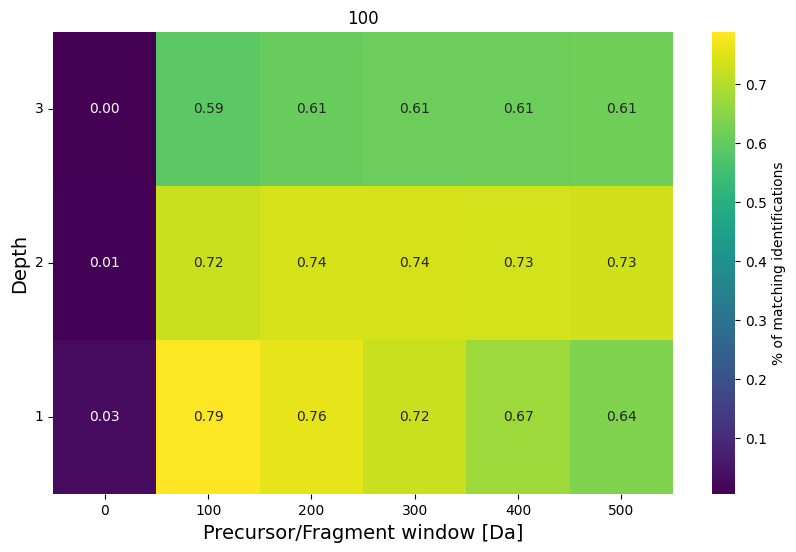

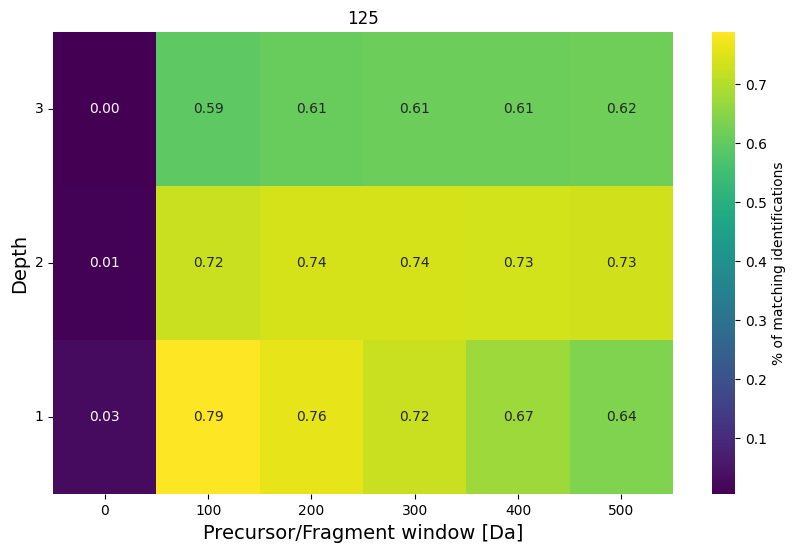

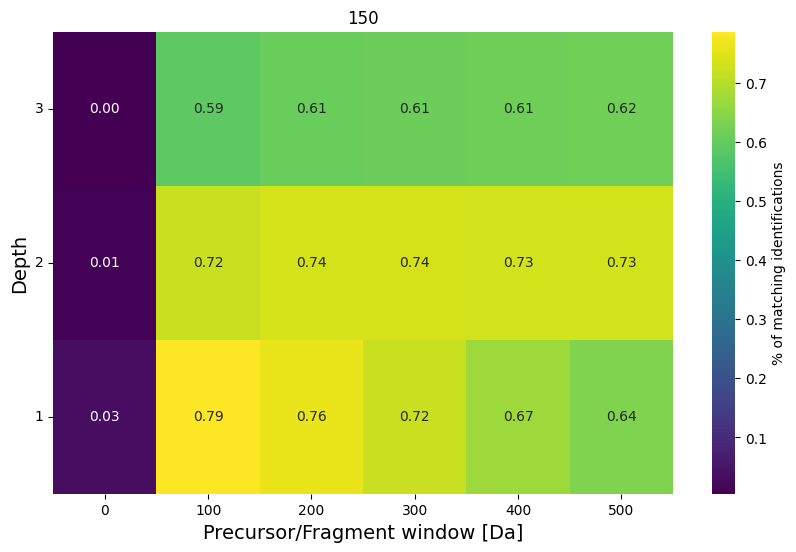

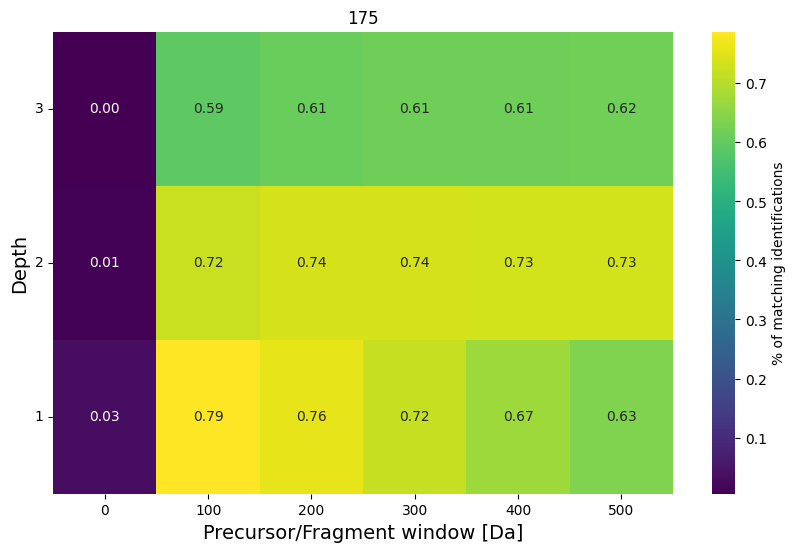

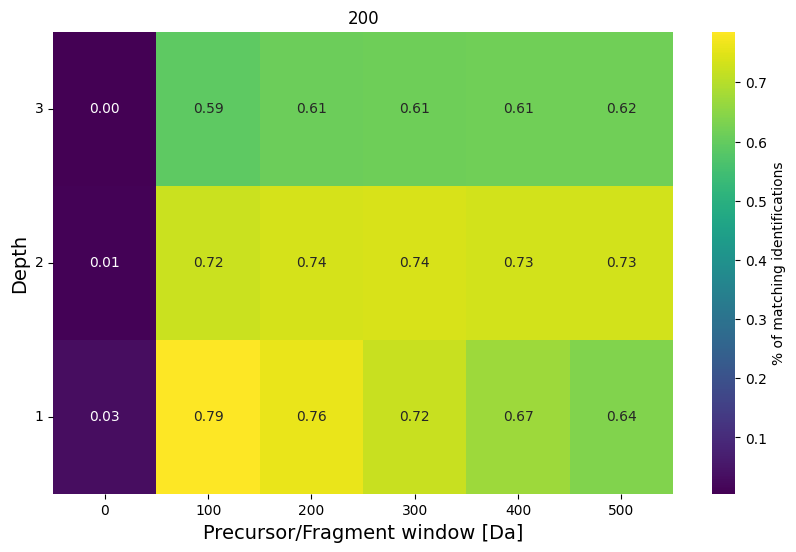

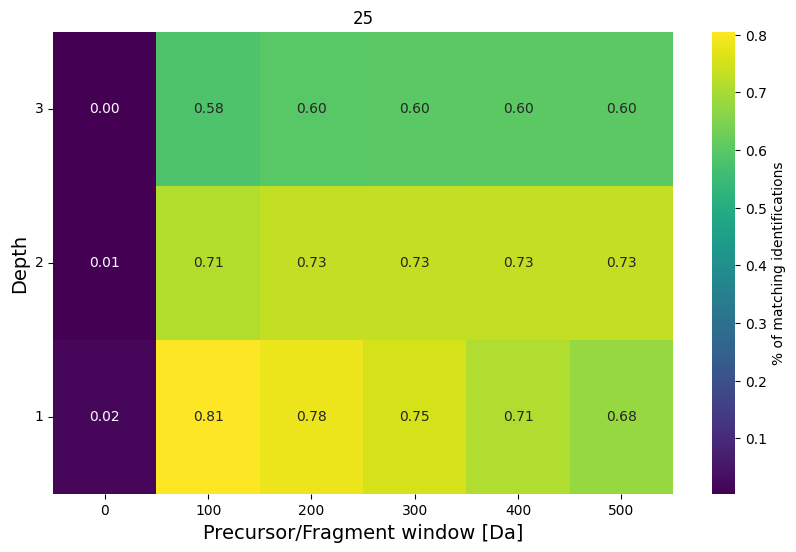

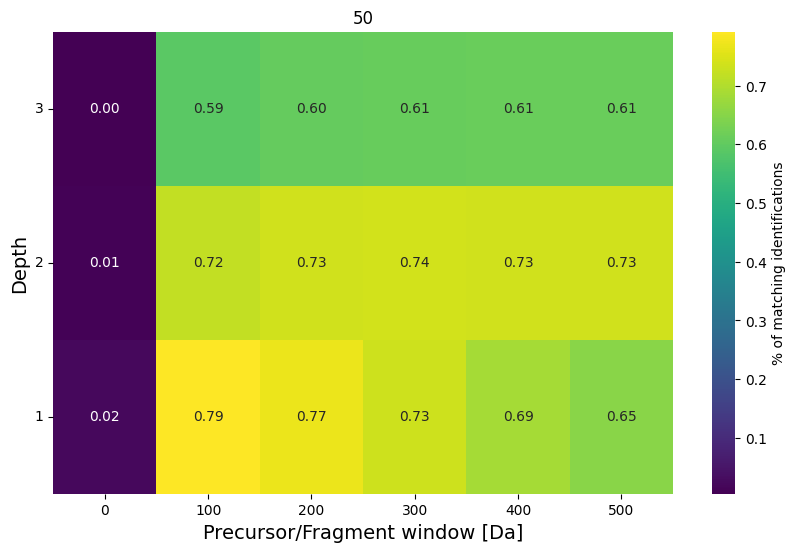

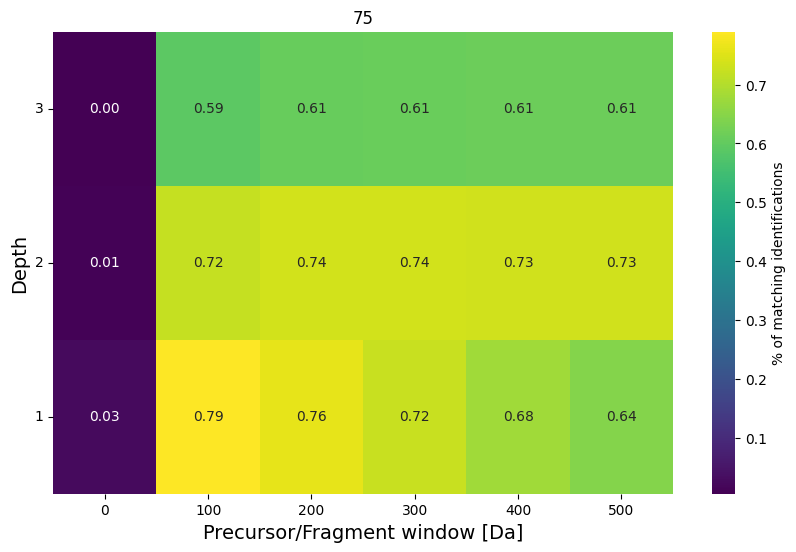

In [43]:
for tol in out["tol"].unique():
    out_temp = out[out["tol"] == tol]
    heatmap_data = out_temp.pivot('depth', 'window', 'ratio_ided')
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f", cbar_kws={'label': '% of matching identifications'})

    plt.yticks(rotation=0)
    plt.gca().invert_yaxis()
    plt.title('')
    plt.ylabel("Depth", size = 14)
    plt.xlabel("Precursor/Fragment window [Da]", size = 14)
    plt.title(tol)
    plt.show()

In [81]:
#eval the histo of the peak number
#how does the tolerance infulence the number of multi peaks?

def eval_number_peaks(folder_path):
    out = pd.DataFrame({"Spectrum ID":[], " #peaks":[]})
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    for file_name in files:
        
        file_path = os.path.join(folder_path, file_name)
        
        depth = file_name[0]
        
        pattern = re.compile(r'^([^\.]+)')
        matches = pattern.search(file_name)
        window = matches.group(1)[1:]
        
        pattern = re.compile(r'\.0*([1-9]\d*)')
        matches = pattern.search(file_name)
        tol = matches.group(1)
        
        
        fi = (pd.read_csv(file_path))[["Spectrum ID", " #peaks"]]
           
        out = pd.concat([out, fi])    
        out = out.drop_duplicates(subset=['Spectrum ID'])     
    return out

In [82]:
num_peaks = eval_number_peaks("out_trunc_diff_depth_fixedprec_difftags/")

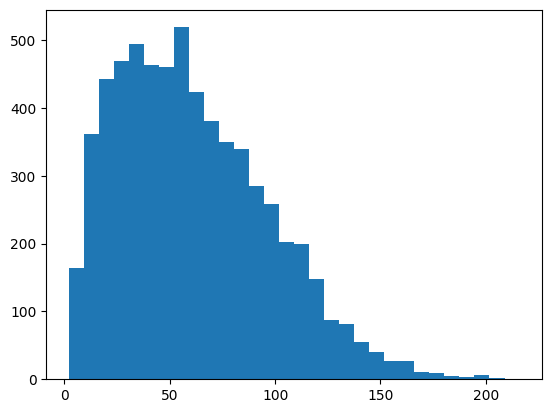

59.06666666666667


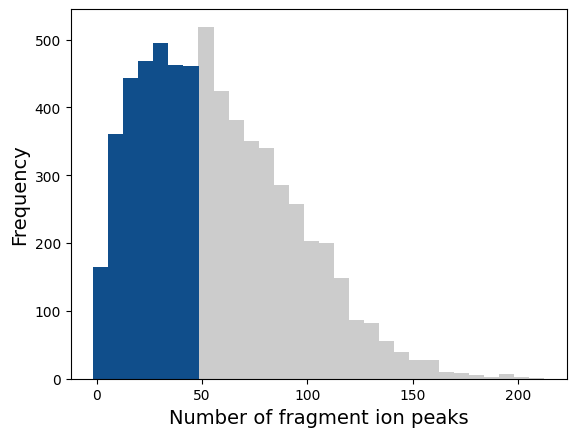

In [94]:
bins_peaks = plt.hist(num_peaks[" #peaks"], bins = 30)
plt.show()
peak_sum = 0
ix = 0
while peak_sum < (sum(bins_peaks[0])/2):
    peak_sum += bins_peaks[0][ix]
    ix+=1
print(bins_peaks[1][ix])
plt.bar(bins_peaks[1][:-1], bins_peaks[0], width = 7.2, color = "#CCCCCC")
plt.bar(bins_peaks[1][:ix-1], bins_peaks[0][:ix-1], width = 7.2, color = "#104E8B")
plt.xlabel("Number of fragment ion peaks", size = 14)
plt.ylabel("Frequency", size = 14)
plt.savefig("MDFIID_number_peaks_histo.png", bbox_inches = 'tight', dpi = 500)

In [72]:
#how does the tolerance infulence the number of multi peaks?

def eval_number_multi_peaks(folder_path):
    out = pd.DataFrame({"tol":[], "depth":[], "window":[], "vector_peaks":[], "vector_mp":[]})
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    for file_name in files:
        
        file_path = os.path.join(folder_path, file_name)
        
        depth = file_name[0]
        
        pattern = re.compile(r'^([^\.]+)')
        matches = pattern.search(file_name)
        window = matches.group(1)[1:]
        
        pattern = re.compile(r'\.0*([1-9]\d*)')
        matches = pattern.search(file_name)
        tol = matches.group(1)
        
        
        fi = pd.read_csv(file_path)
        fi = fi.drop_duplicates(subset=['Spectrum ID'])    
        out = pd.concat([out, pd.DataFrame({"tol": [tol], "depth": [depth], "window": [window], "vector_peaks": [fi[" #peaks"]], "vector_mp": [fi[" #multi-peaks"]]})])    
            
    return out

In [16]:
df_numbers = eval_number_multi_peaks("out_trunc_diff_depth_fixedprec_difftags/")

In [40]:
df_number_mp_histo = df_numbers[(df_numbers["depth"] == "1") & (df_numbers["window"] == "100")]


In [41]:
df_number_mp_histo

,tol,depth,window,vector_peaks,vector_mp,vp_len,vmp_len
0,100,1,100,0 22 50 11 96 10 146 ...,0 19 50 2 96 2 146 ...,6258,6258
0,125,1,100,0 22 50 11 96 10 146 ...,0 19 50 2 96 2 146 ...,6263,6263
0,150,1,100,0 22 50 11 96 10 146 ...,0 19 50 2 96 2 146 ...,6271,6271
0,175,1,100,0 22 50 11 96 10 146 ...,0 19 50 2 96 2 146 ...,6275,6275
0,200,1,100,0 22 50 11 96 10 146 ...,0 19 50 2 96 2 146 ...,6281,6281
0,25,1,100,0 22 50 11 96 10 120 ...,0 16 50 2 96 1 120 ...,6158,6158
0,50,1,100,0 22 50 11 96 10 146 ...,0 18 50 2 96 2 146 ...,6211,6211
0,75,1,100,0 22 50 11 96 10 146 ...,0 19 50 2 96 2 146 ...,6234,6234


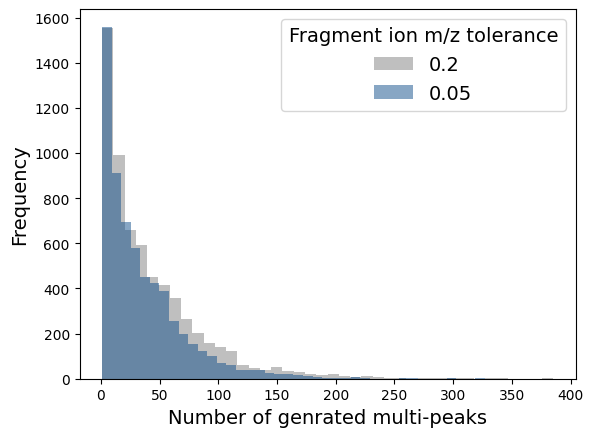

In [99]:
a = plt.hist(df_number_mp_histo["vector_mp"].iloc[4], bins = 40, alpha = 0.5, color = "grey", label = 0.2)

c = plt.hist(df_number_mp_histo["vector_mp"].iloc[6], bins = 40, alpha = 0.5, color = "#104E8B", label = 0.05)
plt.legend(title = "Fragment ion m/z tolerance", title_fontsize = 14, fontsize = 14)
plt.xlabel("Number of genrated multi-peaks", size = 14)
plt.ylabel("Frequency", size = 14)

plt.savefig("multi-peak-frequency.png", bbox_inches = 'tight', dpi = 500)

In [30]:
df_numbers["vp_len"] = [len(x) for x in df_numbers["vector_peaks"]]
df_numbers["vmp_len"] = [len(x) for x in df_numbers["vector_mp"]]

In [31]:
df_numbers.groupby("tol").apply(lambda x: x["vmp_len"])

,tol,depth,window,vector_peaks,vector_mp,vp_len,vmp_len
0,100,1,0,0 49 2 12 4 44 5 4...,0 50 2 9 4 34 5 20 7 ...,2095,2095
0,125,1,0,0 17 1 49 5 12 7 1...,0 4 1 51 5 9 7 5 8 ...,2349,2349
0,150,1,0,0 17 1 49 5 12 7 ...,0 4 1 54 5 9 7 ...,2555,2555
0,175,1,0,0 17 1 49 8 12 10 ...,0 4 1 54 8 9 10 ...,2658,2658
0,200,1,0,0 17 1 49 8 12 10 ...,0 4 1 54 8 9 10 ...,2736,2736
...,...,...,...,...,...,...,...
0,175,3,500,0 22 9 22 20 49 34 1...,0 15 9 18 20 39 34 ...,4034,4034
0,200,3,500,0 22 9 22 20 49 34 1...,0 15 9 18 20 39 34 ...,4042,4042
0,25,3,500,0 22 8 22 11 49 14 4...,0 7 8 14 11 14 14 2...,3779,3779
0,50,3,500,0 22 9 22 20 49 27 1...,0 13 9 18 20 24 27 ...,3938,3938


In [29]:
df_numbers.groupby("tol")["vector_peaks"].apply(lambda x: [len(y) for y in x])

tol
100    [2095, 6258, 6289, 6295, 6296, 6296, 399, 4973...
125    [2349, 6263, 6295, 6303, 6304, 6304, 466, 4986...
150    [2555, 6271, 6301, 6309, 6310, 6310, 519, 4991...
175    [2658, 6275, 6304, 6312, 6313, 6313, 546, 4997...
200    [2736, 6281, 6309, 6318, 6319, 6319, 577, 5004...
25     [696, 6158, 6190, 6195, 6196, 6196, 98, 4769, ...
50     [1338, 6211, 6240, 6247, 6247, 6247, 253, 4917...
75     [1788, 6234, 6264, 6269, 6269, 6269, 333, 4957...
Name: vector_peaks, dtype: object